# A comparison between generator/gan/gan+pretraining

In [58]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os.path as op
import time

# import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint, History, CallbackList, BaseLogger, EarlyStopping
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from skimage import color
from IPython.display import display, HTML
import pandas as pd
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from fastmri_recon.data.test_generators import CifarGenerator
from fastmri_recon.helpers.adversarial_training import compile_models, adversarial_training_loop
from fastmri_recon.helpers.image_tboard_cback import TensorBoardImage
from fastmri_recon.helpers.keras_utils import wasserstein_loss
from fastmri_recon.models.discriminator import discriminator_model, generator_containing_discriminator_multiple_outputs
from fastmri_recon.models.unet import unet
from fastmri_recon.helpers.evaluate import psnr, ssim, mse, nmse

In [3]:
run_params = {
    'n_layers': 4, 
    'pool': 'max', 
    "layers_n_channels": [16, 32, 64, 128], 
    'layers_n_non_lins': 2,
}

im_size = 32

perceptual_loss = 'mae'
discriminator_lr = 1e-4
d_on_reconstructor_lr = 1e-3
AF = 2
sns.set_style('white')

In [4]:
# model definition

def generator_model():
    model = unet(input_size=(im_size, im_size, 1), **run_params, compile=False)
    model.name = 'Reconstructor'
    return model

In [5]:
def show_images(images, cols = 1, title=None, titles = None, scale = 1, savepath=""):
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(facecolor="white")
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)) +1 , n + 1)
        plt.imshow(image,  interpolation='nearest')
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images * scale)
    if savepath !='':
        plt.savefig(savepath)
    plt.show()

In [6]:
# Data loading

(x_train, _), (x_test, _) = cifar10.load_data()

x_train = color.rgb2gray(x_train)
x_test = color.rgb2gray(x_test)

val_gen = CifarGenerator(AF, im_size, x_test, max_size=10000).flow_z_filled_images()
train_gen = CifarGenerator(AF, im_size, x_train, max_size=50000).flow_z_filled_images()

## 1. Generator training

In [7]:
gen = generator_model()
d = discriminator_model(im_size)
d_on_g = generator_containing_discriminator_multiple_outputs(gen, d, im_size=im_size)

compile_models(
    d, 
    gen, 
    d_on_g, 
    d_lr=discriminator_lr, 
    d_on_g_lr=d_on_reconstructor_lr, 
    perceptual_loss=perceptual_loss, 
    perceptual_weight=1.0,
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [8]:
run_id = f'unet_gan_af{AF}_{int(time.time())}'
chkpt_path = f'../checkpoints/{run_id}' + '-{epoch:02d}.hdf5'
print(run_id)

unet_gan_af2_1576056307


In [9]:
# callbacks definition

log_dir = op.join('logs/training', run_id)

tqdm_cb = TQDMNotebookCallback(metric_format="{name}: {value:e}")

tboard_cback = TensorBoard(
    log_dir=log_dir, 
    write_graph=True, 
    update_freq=50,
)

chkpt_cback = ModelCheckpoint(chkpt_path, period=100)

selected_slice = 0

data = next(val_gen)

tboard_image_cback = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

log_dir_pre = op.join('logs/pretraining', run_id)

tboard_cback_pre = TensorBoard(
    log_dir=log_dir_pre, 
    write_graph=True, 
    update_freq=50)

tqdm_cb_pre = TQDMNotebookCallback(outer_description = "Pre-training", metric_format="{name}: {value:e}")

tboard_image_cback_pre = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/data/test_generators.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/helpers/reconstruction.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


In [10]:
%%time
# training
hist = adversarial_training_loop(
    gen, 
    d, 
    d_on_g, 
    train_gen, 
    n_epochs=0, 
    n_batches=100, 
    n_critic_updates=5,
    callbacks=[tqdm_cb, tboard_cback, tboard_image_cback, chkpt_cback],
    include_d_metrics=True,
    gen_pre_training_steps=20,
    pre_training_callbacks=[tqdm_cb_pre, tboard_cback_pre, tboard_image_cback_pre, chkpt_cback]
)

OSError: Unable to create file (unable to open file: name = 'checkpoints/unet_gan_af2_1576056307-100.hdf5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

In [11]:
ev_generator = gen.evaluate_generator(val_gen, steps=200, callbacks=None, verbose=1)
print('test loss, psnr,ssim:', ev_generator)


200/200 [==============================] - 8s 42ms/step
test loss, psnr,ssim: [0.16147290170192719, 14.816193580627441, 0.47518494725227356, 0.026720771566033363]


In [12]:
# reset the validation data generator
val_gen = CifarGenerator(AF, im_size, x_test, max_size=10000).flow_z_filled_images()

In [17]:
im_alias, im_true = next(val_gen)
im_pred = gen.predict(im_alias)

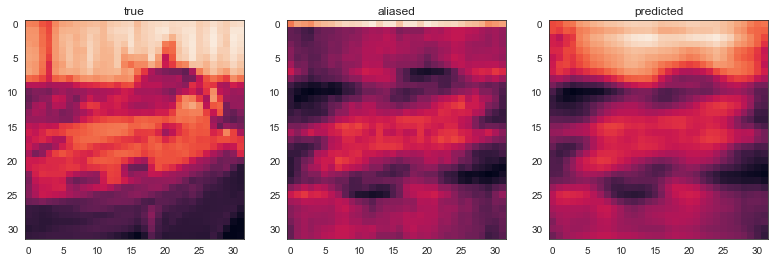

PSNR aliased image:  4.525175839610387 
PSNR predicted image: 13.784794684481545

MSE aliased image:  0.326778220205456 
MSE predicted image: 0.03875174097689414

NMSE aliased image:  0.9934209367867879 
NMSE predicted image: 0.11780708885427238


In [18]:
show_images([np.squeeze(im_true), np.squeeze(im_alias),np.squeeze(im_pred)],
            titles=["true", "aliased", "predicted"])
print("PSNR aliased image: ", psnr(im_true, im_alias), "\nPSNR predicted image:", psnr(im_true, im_pred))
# print("ssim aliased image: ", ssim(im_true, im_alias), "\nssim predicted image:", ssim(im_true, im_pred))
print("\nMSE aliased image: ", mse(im_true, im_alias), "\nMSE predicted image:", mse(im_true, im_pred))
print("\nNMSE aliased image: ", nmse(im_true, im_alias), "\nNMSE predicted image:", nmse(im_true, im_pred))

## 2. Gan training


In [19]:
gan = generator_model()
d = discriminator_model(im_size)
d_on_g = generator_containing_discriminator_multiple_outputs(gan, d, im_size=im_size)

compile_models(
    d, 
    gan, 
    d_on_g, 
    d_lr=discriminator_lr, 
    d_on_g_lr=d_on_reconstructor_lr, 
    perceptual_loss=perceptual_loss, 
    perceptual_weight=1.0,
)

In [20]:
run_id = f'unet_gan_af{AF}_{int(time.time())}'
chkpt_path = f'checkpoints/{run_id}' + '-{epoch:02d}.hdf5'
print(run_id)

unet_gan_af2_1576057041


In [59]:
# callbacks definition

log_dir = op.join('logs/training', run_id)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=0,
                          verbose=0, mode='auto')

tqdm_cb = TQDMNotebookCallback(metric_format="{name}: {value:e}")

tboard_cback = TensorBoard(
    log_dir=log_dir, 
    write_graph=True, 
    update_freq=50,
)

chkpt_cback = ModelCheckpoint(chkpt_path, period=100)

selected_slice = 0

data = next(val_gen)

tboard_image_cback = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

log_dir_pre = op.join('logs/pretraining', run_id)

tboard_cback_pre = TensorBoard(
    log_dir=log_dir_pre, 
    write_graph=True, 
    update_freq=50)

tqdm_cb_pre = TQDMNotebookCallback(outer_description = "Pre-training", metric_format="{name}: {value:e}")

tboard_image_cback_pre = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

In [61]:
%%time
# training
hist = adversarial_training_loop(
    gan, 
    d, 
    d_on_g, 
    train_gen, 
    val_gen,
    validation_steps=1,
    n_epochs=100, 
    n_batches=5, 
    n_critic_updates=5,
    callbacks=[tqdm_cb, tboard_cback, tboard_image_cback, earlystop],
    include_d_metrics=True,
    gen_pre_training_steps=0,
    pre_training_callbacks=[tqdm_cb_pre, tboard_cback_pre, tboard_image_cback_pre]
)

/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: val_Reconstructor/loss,val_Reconstructor/keras_psnr,val_Reconstructor/keras_ssim,val_Reconstructor/mse,loss,Reconstructor/loss,Discriminator/loss,Reconstructor/keras_psnr,Reconstructor/keras_ssim,Reconstructor/mse,d_training/loss_fake,d_training/mean_output_fake,d_training/discriminator_accuracy_fake,d_training/loss_real,d_training/mean_output_real,d_training/discriminator_accuracy_real
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



CPU times: user 8min 15s, sys: 3min 23s, total: 11min 38s
Wall time: 15min 36s


In [66]:
ev_gan = gan.evaluate_generator(val_gen, steps=200, callbacks=None, verbose=1)
print('test loss, psnr,ssim:', ev_gan)

200/200 [==============================] - 7s 33ms/step
test loss, psnr,ssim: [0.2805113196372986, 9.833728790283203, 0.10053287446498871, 0.08096718788146973]


In [67]:
# reset the validation data generator
val_gen = CifarGenerator(AF, im_size, x_test, max_size=10000).flow_z_filled_images()

In [68]:
im_alias, im_true = next(val_gen)
im_pred = gan.predict(im_alias)

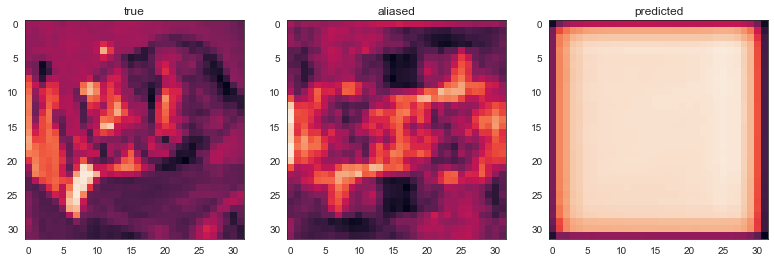

PSNR aliased image:  5.64610240199804 
PSNR predicted image: 11.308824598772237

MSE aliased image:  0.20671858858204917 
MSE predicted image: 0.056118662454725986

NMSE aliased image:  0.9927788877449575 
NMSE predicted image: 0.26951336924121966


In [69]:
show_images([np.squeeze(im_true), np.squeeze(im_alias),np.squeeze(im_pred)],
            titles=["true", "aliased", "predicted"])
print("PSNR aliased image: ", psnr(im_true, im_alias), "\nPSNR predicted image:", psnr(im_true, im_pred))
# print("ssim aliased image: ", ssim(im_true, im_alias), "\nssim predicted image:", ssim(im_true, im_pred))
print("\nMSE aliased image: ", mse(im_true, im_alias), "\nMSE predicted image:", mse(im_true, im_pred))
print("\nNMSE aliased image: ", nmse(im_true, im_alias), "\nNMSE predicted image:", nmse(im_true, im_pred))

## 3. GAN training with generator pretraining

In [29]:
pregan = generator_model()
d = discriminator_model(im_size)
d_on_g = generator_containing_discriminator_multiple_outputs(pregan, d, im_size=im_size)

compile_models(
    d, 
    pregan, 
    d_on_g, 
    d_lr=discriminator_lr, 
    d_on_g_lr=d_on_reconstructor_lr, 
    perceptual_loss=perceptual_loss, 
    perceptual_weight=1.0,
)

In [30]:
run_id = f'unet_gan_af{AF}_{int(time.time())}'
chkpt_path = f'checkpoints/{run_id}' + '-{epoch:02d}.hdf5'
print(run_id)

unet_gan_af2_1576057387


In [31]:
# callbacks definition

log_dir = op.join('logs/training', run_id)

earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=0,
                              verbose=0, mode='auto')

tqdm_cb = TQDMNotebookCallback(metric_format="{name}: {value:e}")

tboard_cback = TensorBoard(
    log_dir=log_dir, 
    write_graph=True, 
    update_freq=50,
)

chkpt_cback = ModelCheckpoint(chkpt_path, period=100)

selected_slice = 0

data = next(val_gen)

tboard_image_cback = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

log_dir_pre = op.join('logs/pretraining', run_id)

tboard_cback_pre = TensorBoard(
    log_dir=log_dir_pre, 
    write_graph=True, 
    update_freq=50)

tqdm_cb_pre = TQDMNotebookCallback(outer_description = "Pre-training", metric_format="{name}: {value:e}")

tboard_image_cback_pre = TensorBoardImage(
    log_dir=log_dir + '/images',
    image=data[1][selected_slice:selected_slice+1],
    # NOTE: for cross-domain slice has to be on kspace and mask
    model_input=data[0][selected_slice:selected_slice+1],
)

In [32]:
%%time
# training
hist = adversarial_training_loop(
    pregan, 
    d, 
    d_on_g, 
    train_gen, 
    n_epochs=50, 
    n_batches=1, 
    n_critic_updates=5,
    callbacks=[tqdm_cb, tboard_cback, tboard_image_cback],
    include_d_metrics=True,
    gen_pre_training_steps=5,
    pre_training_callbacks=[tqdm_cb_pre, tboard_cback_pre, tboard_image_cback_pre]
)

/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/data/test_generators.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/WorkAccount/miniconda3/envs/gan/lib/python3.7/site-packages/fastmri_recon-0.0.1-py3.7.egg/fastmri_recon/helpers/reconstruction.py:40: ComplexWarning: Casting complex values to real discards the imaginary part



CPU times: user 2min 17s, sys: 43.2 s, total: 3min
Wall time: 7min 20s


In [62]:
ev_pregan = pregan.evaluate_generator(val_gen, steps=200, callbacks=None, verbose=1)
print('test loss, psnr,ssim:', ev_pregan)

200/200 [==============================] - 15s 76ms/step
test loss, psnr,ssim: [0.12244211137294769, 14.193387031555176, 0.3890073001384735, 0.03203025832772255]


In [63]:
# reset the validation data generator
val_gen = CifarGenerator(AF, im_size, x_test, max_size=10000).flow_z_filled_images()

In [64]:
im_alias, im_true = next(val_gen)
im_pred = pregan.predict(im_alias)

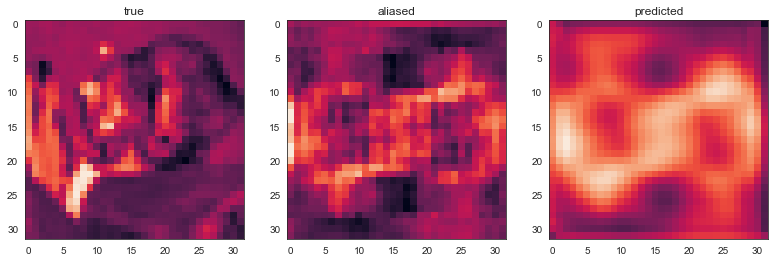

PSNR aliased image:  5.646084076148065 
PSNR predicted image: 16.321807540543677

MSE aliased image:  0.2067194608707823 
MSE predicted image: 0.017693307167987844

NMSE aliased image:  0.9927830769658891 
NMSE predicted image: 0.08497320889839997


In [65]:
show_images([np.squeeze(im_true), np.squeeze(im_alias),np.squeeze(im_pred)],
            titles=["true", "aliased", "predicted"])
print("PSNR aliased image: ", psnr(im_true, im_alias), "\nPSNR predicted image:", psnr(im_true, im_pred))
# print("ssim aliased image: ", ssim(im_true, im_alias), "\nssim predicted image:", ssim(im_true, im_pred))
print("\nMSE aliased image: ", mse(im_true, im_alias), "\nMSE predicted image:", mse(im_true, im_pred))
print("\nNMSE aliased image: ", nmse(im_true, im_alias), "\nNMSE predicted image:", nmse(im_true, im_pred))

# Comparison

In [37]:
styles = [dict(props=[("font-size", "130%"),("text-align", "center")])]
df = pd.DataFrame([ev_generator, ev_gan, ev_pregan], columns = ['loss' , 'psnr', 'ssim', 'mse']) 
df.insert(0, '', ["generator", "gan", "pregan"])
html = (df.style.set_table_styles(styles))
# print("Evaluation Table:")
display(html)

,,loss,psnr,ssim,mse
0,generator,0.161473,14.8162,0.475185,0.0267208
1,gan,0.318018,9.82458,0.100832,0.0812093
2,pregan,0.216541,9.88263,0.105217,0.0874713


In [ ]:
val_gen = CifarGenerator(AF, im_size, x_test, max_size=10000).flow_z_filled_images()

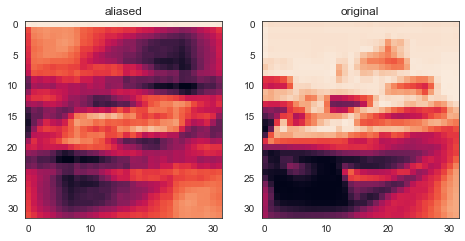

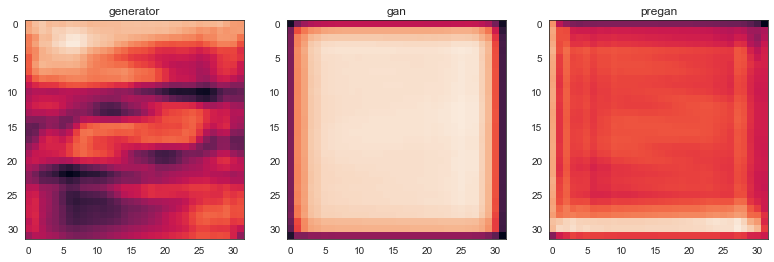

In [57]:
im_alias, im_true = next(val_gen)

im1 = gen.predict(im_alias)
im2 = gan.predict(im_alias)
im3 = pregan.predict(im_alias)
show_images([np.squeeze(im_alias), np.squeeze(im_true)],
            titles=["aliased", "original"])
show_images([np.squeeze(im1), np.squeeze(im2), np.squeeze(im3)], titles=["generator", "gan", "pregan"])

In [71]:
import tensorboard
import os
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
